# Machine Learning for Customer Churn Prediction

Project Description:
Beta Bank customers are leaving: little by little, chipping away every month. The bankers figured out it’s cheaper to save the existing customers rather than to attract new ones.
We need to predict whether a customer will leave the bank soon. You have the data on clients’ past behavior and termination of contracts with the bank.
Build a model with the maximum possible F1 score. To pass the project, you need an F1 score of at least 0.59. Check the F1 for the test set.
Additionally, measure the AUC-ROC metric and compare it with the F1.

Data Description:
The data can be found in /datasets/Churn.csv file. Download the dataset.

Features:
RowNumber — data string index
CustomerId — unique customer identifier
Surname — surname
CreditScore — credit score
Geography — country of residence
Gender — gender
Age — age
Tenure — period of maturation for a customer’s fixed deposit (years)
Balance — account balance
NumOfProducts — number of banking products used by the customer
HasCrCard — customer has a credit card
IsActiveMember — customer’s activeness
EstimatedSalary — estimated salary

Target:
Exited — сustomer has left

## Download and Prepare the Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
import itertools
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('/datasets/Churn.csv')

display(df.head())
display(df.info())

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             9091 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


None

### Prepare Data for Model

In [3]:
#Drop Columns that do not affect the model
df.drop(['RowNumber', 'CustomerId', 'Surname'], axis = 1, inplace=True)

df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [4]:
#Check for duplicates
df.duplicated().sum()


0

In [5]:
#Check for missing values
df.isnull().sum()

CreditScore          0
Geography            0
Gender               0
Age                  0
Tenure             909
Balance              0
NumOfProducts        0
HasCrCard            0
IsActiveMember       0
EstimatedSalary      0
Exited               0
dtype: int64

In [6]:
display(df['Tenure'].unique())

#Replace missing values with -1
df['Tenure'] = df['Tenure'].fillna(-1)

df.isnull().sum()

array([ 2.,  1.,  8.,  7.,  4.,  6.,  3., 10.,  5.,  9.,  0., nan])

CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [7]:
#Tranform categorical features into numerical
encoder = OrdinalEncoder()
df_ordinal = pd.DataFrame(encoder.fit_transform(df), columns=df.columns)

display(df_ordinal.head())
df_ordinal.info()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,228.0,0.0,0.0,24.0,3.0,0.0,0.0,1.0,1.0,5068.0,1.0
1,217.0,2.0,0.0,23.0,2.0,743.0,0.0,0.0,1.0,5639.0,0.0
2,111.0,0.0,0.0,24.0,9.0,5793.0,2.0,1.0,0.0,5707.0,1.0
3,308.0,0.0,0.0,21.0,2.0,0.0,1.0,0.0,0.0,4704.0,0.0
4,459.0,2.0,0.0,25.0,3.0,3696.0,0.0,1.0,1.0,3925.0,0.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
CreditScore        10000 non-null float64
Geography          10000 non-null float64
Gender             10000 non-null float64
Age                10000 non-null float64
Tenure             10000 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null float64
HasCrCard          10000 non-null float64
IsActiveMember     10000 non-null float64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null float64
dtypes: float64(11)
memory usage: 859.5 KB


In [8]:
#Label target and features for model
target = df_ordinal['Exited']
features = df_ordinal.drop('Exited', axis=1)

In [9]:
#Split data
features_train_valid, features_test, target_train_valid, target_test = train_test_split(
        features, target, test_size=0.2, random_state=123)
features_train, features_valid, target_train, target_valid = train_test_split(
        features_train_valid, target_train_valid, test_size=0.25, random_state=123)

#Check if data is split correct
display(len(features_train))
display(len(features_test))
display(len(features_valid))

6000

2000

2000

In [10]:
#Equally scale numerical features
scaler = StandardScaler()
numeric = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary']
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])

features_valid[numeric] = scaler.transform(features_valid[numeric])

features_test[numeric] = scaler.transform(features_test[numeric])

display(features_train.head())
display(features_valid.head())
display(features_test.head())

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
8189,0.652823,0.0,1.0,-1.700024,9.0,-0.950460,1.0,1.0,0.0,-0.539820
8845,0.797391,1.0,0.0,0.002775,2.0,1.025270,0.0,1.0,1.0,1.629777
1165,0.621844,1.0,0.0,0.948774,6.0,1.692765,1.0,0.0,0.0,1.670968
1742,-0.699922,1.0,0.0,1.421774,2.0,-0.720451,0.0,0.0,0.0,0.681011
1139,0.776739,2.0,0.0,1.705574,2.0,0.148889,0.0,0.0,1.0,-1.704923


,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
1361,-0.761879,0.0,1.0,-0.659425,5.0,-0.950460,1.0,1.0,1.0,0.743316
2739,-0.276543,0.0,1.0,0.570375,8.0,1.228992,0.0,0.0,0.0,0.443560
1963,-0.761879,1.0,1.0,-0.470225,0.0,1.526596,1.0,1.0,0.0,-0.572703
9799,0.012593,0.0,1.0,0.664975,1.0,0.533802,0.0,1.0,0.0,-0.376789
1023,-0.100996,0.0,1.0,-0.659425,4.0,-0.950460,1.0,1.0,1.0,-0.188836


,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
2656,1.313706,2.0,0.0,-0.470225,6.0,-0.950460,1.0,0.0,1.0,0.219608
445,0.993591,0.0,0.0,-1.227024,2.0,-0.712941,0.0,0.0,1.0,1.453593
9505,-0.008060,0.0,1.0,-1.037824,11.0,-0.684776,0.0,1.0,1.0,-0.440478
332,0.115856,1.0,1.0,0.475775,3.0,0.438043,1.0,0.0,1.0,0.795583
4168,-1.402110,0.0,1.0,-0.186425,9.0,-0.950460,0.0,1.0,0.0,0.043423


The data set contains 14 columns and 1000 entries. Columns RowNumber, CustomerId, and Surname have no importance to the model so they were removed. There are three data types: integer, float, and object. There was no duplicate entries in the data. The column 'Tenure' has 909 missing values. The missing values make up 9.09% of data, it is too much to remove. We replaced missing values with -1.

We tranformed categorical values to numerical using ordinal encoder. We scaled numerical values using standard scaler. We split the data in to a training set, test set, and validation set. The training set is 60% of data, the test test is 20% of data, and the validation set is 20% of data.

## Examine the Balance of Classes. Train the Model Without Taking into Account the Imbalance. Briefly Describe Your Findings.

### Examine the Balance of Classes

0.0    7963
1.0    2037
Name: Exited, dtype: int64

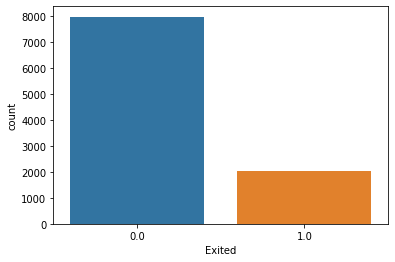

In [11]:
#Examine the balance of classes
sns.countplot(df_ordinal['Exited'])

display(df_ordinal['Exited'].value_counts())

We examined the balance of classes. As you can see from the graph the classes are imbalanced.

### Train the Model Without Balance

In [12]:
#Random Forest Classifier
model = RandomForestClassifier(random_state=123)
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
print('F1_Score is:', f1_score(target_valid, predicted_valid))
print('Roc-Auc Score:', roc_auc_score(target_valid, predicted_valid))

F1_Score is: 0.5446153846153846
Roc-Auc Score: 0.6939421338155516


In [13]:
#Logistic Regression 
model = LogisticRegression(random_state=123)
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
print('F1_Score is:', f1_score(target_valid, predicted_valid))
print('Roc-Auc Score:', roc_auc_score(target_valid, predicted_valid))

F1_Score is: 0.22265625
Roc-Auc Score: 0.5567811934900542


In [14]:
#Decision Tree Classifier
model = DecisionTreeClassifier(random_state=123)
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
print('F1_Score is:', f1_score(target_valid, predicted_valid))
print('Roc-Auc Score:', roc_auc_score(target_valid, predicted_valid))

F1_Score is: 0.4621026894865526
Roc-Auc Score: 0.6588607594936708


We trained the model without balancing the data.  The worst is the logistic regression model, with a F1 score of 22.27%. The F1 score is best in the random tree model, a score of 54.62%. This is an okay score but still not good enough lets look at balancing the data next.

## Improve the Quality of the Model

### Upsampling

In [15]:
#Function for upsampling
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)

    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=123)
    
    return features_upsampled, target_upsampled


features_upsampled, target_upsampled = upsample(
    features_train, target_train, 4
)

target_upsampled.value_counts()

1.0    4812
0.0    4797
Name: Exited, dtype: int64

In [16]:
#Logistic Regression
model = LogisticRegression(random_state=123)
model.fit(features_upsampled,target_upsampled)
predicted_valid = model.predict(features_valid)
print('F1 Score:', f1_score(target_valid, predicted_valid))

#Roc-Auc Score
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
print('Roc-Auc Score:', roc_auc_score(target_valid, probabilities_one_valid))

F1 Score: 0.48316498316498313
Roc-Auc Score: 0.7508966244725738


In [17]:
#Decision Tree Classifier
model = DecisionTreeClassifier(random_state=123)
model.fit(features_upsampled,target_upsampled)
predicted_valid = model.predict(features_valid)
print('F1 Score:', f1_score(target_valid, predicted_valid))

#Roc-Auc Score
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
print('Roc-Auc Score:', roc_auc_score(target_valid, probabilities_one_valid))

F1 Score: 0.510948905109489
Roc-Auc Score: 0.6892405063291139


In [18]:
#Random Forest Classifier
model = RandomForestClassifier(random_state=123)
model.fit(features_upsampled,target_upsampled)
predicted_valid = model.predict(features_valid)
print('F1 Score:', f1_score(target_valid, predicted_valid))

#Roc-Auc Score
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
print('Roc-Auc Score:', roc_auc_score(target_valid, probabilities_one_valid))

F1 Score: 0.5494505494505494
Roc-Auc Score: 0.8023131404460517


### Downsampling

In [19]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=123)]
        + [features_ones]
    )
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=123)]
        + [target_ones]
    )

    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=123
    )

    return features_downsampled, target_downsampled


features_downsampled, target_downsampled = downsample(
    features_train, target_train, 0.251
)

target_downsampled.value_counts()

0.0    1204
1.0    1203
Name: Exited, dtype: int64

In [20]:
#Logistic Regression
model = LogisticRegression(random_state=123)
model.fit(features_downsampled,target_downsampled)
predicted_valid = model.predict(features_valid)
print('F1 Score:', f1_score(target_valid, predicted_valid))

#Roc-Auc Score
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
print('Roc-Auc Score:', roc_auc_score(target_valid, probabilities_one_valid))

F1 Score: 0.4851569126378286
Roc-Auc Score: 0.7527652200120554


In [21]:
#Decision Tree Classifier
model = DecisionTreeClassifier(random_state=123)
model.fit(features_downsampled,target_downsampled)
predicted_valid = model.predict(features_valid)
print('F1 Score:', f1_score(target_valid, predicted_valid))

#Roc-Auc Score
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
print('Roc-Auc Score:', roc_auc_score(target_valid, probabilities_one_valid))

F1 Score: 0.4816053511705685
Roc-Auc Score: 0.6884267631103074


In [22]:
#Random Forest Classifier
model = RandomForestClassifier(random_state=123)
model.fit(features_downsampled,target_downsampled)
predicted_valid = model.predict(features_valid)
print('F1 Score:', f1_score(target_valid, predicted_valid))

#Roc-Auc Score
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
print('Roc-Auc Score:', roc_auc_score(target_valid, probabilities_one_valid))

F1 Score: 0.5524193548387096
Roc-Auc Score: 0.8116289933694997


### Class Weight Adjustment

In [23]:
#Logistic Regression
model = LogisticRegression(random_state=123, solver='liblinear', class_weight = 'balanced') 
model.fit(features_train,target_train)
predictions_valid = model.predict(features_valid)
print('F1 Score:', f1_score(target_valid,predictions_valid))

#Roc-Auc Score
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
print('Roc-Auc Score:', roc_auc_score(target_valid, probabilities_one_valid))

F1 Score: 0.48316498316498313
Roc-Auc Score: 0.7508905967450272


In [24]:
#Decision Tree Classifier
best_score = 0
best_depth = 0
for depth in range(1,100):
    model = DecisionTreeClassifier(random_state=123, max_depth = depth, class_weight = 'balanced')
    model.fit(features_train,target_train)
    predictions_valid = model.predict(features_valid)
    score = f1_score(target_valid, predictions_valid)
    if score > best_score:
        best_score = score
        best_depth = depth
print('Max Depth =', best_depth, 'F1 Score:', best_score)

#Roc-Auc Score
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
print('Roc-Auc Score:', roc_auc_score(target_valid, probabilities_one_valid))

Max Depth = 4 F1 Score: 0.5482456140350878
Roc-Auc Score: 0.6993068113321278


In [25]:
#Random Forest Claffifier
best_depth = 0
best_score = 0
best_n_estimator = 0
for n, depth in itertools.product(range(1,100,10), range(1,100,10)):
    model = RandomForestClassifier(random_state=123, max_depth = depth, n_estimators = n, class_weight = 'balanced')
    model.fit(features_train,target_train)
    predictions_valid = model.predict(features_valid)
    score = f1_score(target_valid, predictions_valid)
    if score > best_score:
        best_score = score
        best_n_estimator = n
        best_depth = depth
print('n_estimator =', best_n_estimator, 'max_depth =', best_depth, 'F1 Score:', best_score)

#Roc-Auc Score
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
print('Roc-Auc Score:', roc_auc_score(target_valid, probabilities_one_valid))

n_estimator = 91 max_depth = 11 F1 Score: 0.5939553219448094
Roc-Auc Score: 0.8307278481012659


We used upsampling, downsampling, and class weight adjustment to balance the data. The best F1 score was obtained for the logistic regression model by using downsampling. The F1 Score was 48.52%. The best F1 score for the decision tree classifier model was 54.82%, this was obtained by class weight adjustment. The model that had the best F1 score overall was the Random Forest Classifier with n_estimators=91 and max_depth=11. The model obtained a F1 score of 59.40% by using the class weight adjustment to balance classes. 

## Perform Final Test

In [26]:
model = RandomForestClassifier(random_state = 123, max_depth = 11, n_estimators = 91, class_weight = 'balanced')
model.fit(features_train, target_train)
predict_test = model.predict(features_test)
f1_score = f1_score(target_test, predict_test)
print('F1 Score:', f1_score)

F1 Score: 0.6313131313131314


Roc-Auc Score: 0.8643733513655111


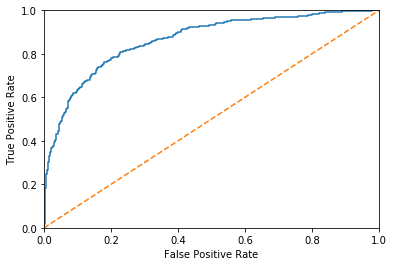

In [27]:
#Roc Curve
probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]

fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)# < write code here >

plt.figure()

plt.plot(fpr,tpr)# < plot the graph >

# ROC curve for random model (looks like a straight line)
plt.plot([0, 1], [0, 1], linestyle='--')

plt.xlim([0,1])
plt.ylim([0,1])# < use the functions plt.xlim() and plt.ylim() to
# set the boundary for the axes from 0 to 1 >

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

#Roc-Auc Score
print('Roc-Auc Score:', roc_auc_score(target_test, probabilities_one_test))

The best model for our data was the random forest classifier with n_estimatores=91 and max_depth=11. We obtained an F1 score of 63.13% and an roc-auc score of 86.44%. The model passed the F1 score threshold of 59%.

## Conclusion

The only missing data was from the column 'Tenure'. The percentage of missing values was too high to remove them. We replaced missing values with -1. We tranformed categorical values to numerical using the ordinal encoder function and we scaled numerical values using the standard scaler function. 

We obtained a F1 score of 63.13% from our data. To obtain a high F1 score we tested multiple models with different hyperparmeters. The classes were imbalanced for our data. We used upsampling, downsampling, and class weight adjustment to balance the classes out. The best result for balancing classes was by class weight adjustment. We found that the best model for our data ws the random forest tree model with n_estimators=91 and max_depth=11. Based on our finding we have obtained a great model for our data.